In [2]:
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
from matplotlib import colors
import pandas as pd

# Load in TPM data 
whisker = pd.read_csv('TPM matrix.csv')
soleus = pd.read_csv('Soleus TPM matrix.csv')

# Load significant transcripts
wsig = pd.read_csv('sig_whisker.csv')
solsig = pd.read_csv('sig_soleus.csv')

# Concatenate significant transcripts from both datasets and then de-duplicate and sort by target_id so we can append
# the q-values onto sig_whisker and sig_soleus so we can sort those by q-value
siglist = wsig.append(solsig)
siglist = siglist.drop_duplicates(subset="target_id")
siglist = siglist.sort_values("target_id").reset_index(drop=True)

# Filter TPM data so only total significant transcripts remain and add q-values
sig_whisker = whisker.loc[whisker["Transcript_ID"].isin(siglist["target_id"])].reset_index(drop=True)
sig_soleus = soleus.loc[soleus["Transcript_ID"].isin(siglist["target_id"])].reset_index(drop=True)
sig_whisker = pd.concat([sig_whisker, siglist["qval"]], axis=1, sort=False)
sig_soleus = pd.concat([sig_soleus, siglist["qval"]], axis=1, sort=False)

# Re-sorting based off of the q-value
sig_whisker = sig_whisker.sort_values("qval").reset_index(drop=True)
sig_soleus = sig_soleus.sort_values("qval").reset_index(drop=True)
siglist = siglist.sort_values("qval").reset_index(drop=True)

#Int location within dataframes, selecting out columns to group for z-scoring
zwhiskd1 = sig_whisker.iloc[:,1:7]
zwhiskd3 = sig_whisker.iloc[:,7:13]
zwhiskd7 = sig_whisker.iloc[:,13:20]
zsol = sig_soleus.iloc[:,1:5]

#Transposed because it's easier to Z-score by column
zwhiskd1 = zwhiskd1.T
zwhiskd3 = zwhiskd3.T
zwhiskd7 = zwhiskd7.T
zsol = zsol.T

#Z-scoring data
zwhiskd1 = zwhiskd1.apply(zscore)
zwhiskd3 = zwhiskd3.apply(zscore)
zwhiskd7 = zwhiskd7.apply(zscore)
zsol = zsol.apply(zscore)

#Remove Z-scores of sham/control samples 
zwhisd1 = pd.concat([zwhiskd1.iloc[1,:], zwhiskd1.iloc[3,:], zwhiskd1.iloc[5,:]], axis = 1, sort = False)
zwhisd3 = pd.concat([zwhiskd3.iloc[1,:], zwhiskd3.iloc[3,:], zwhiskd3.iloc[5,:]], axis = 1, sort = False)
zwhisd7 = pd.concat([zwhiskd7.iloc[1,:], zwhiskd7.iloc[3,:], zwhiskd7.iloc[5,:]], axis = 1, sort = False)
zso = pd.concat([zsol.iloc[1,:],zsol.iloc[3,:]], axis = 1, sort = False)

#Re-Transpose
zwhisd1 = zwhisd1.T
zwhisd3 = zwhisd3.T
zwhisd7 = zwhisd7.T
zso = zso.T

#Average only injured Z-scores
zwhisd1 = zwhisd1.mean(axis=0)
zwhisd3 = zwhisd3.mean(axis=0)
zwhisd7 = zwhisd7.mean(axis=0)
zso = zso.mean(axis=0)

#Concatenate with initial transcript ID's and qvalues and combine into a single dataframe
zwhiszso = pd.concat([sig_whisker.iloc[:,0], zwhisd1, zwhisd3, zwhisd7, zso, sig_whisker.iloc[:,19]], axis = 1, sort = False)

#Make sure Z-score columns are labeled properly
zwhiszso = zwhiszso.rename(index = str, columns = {0:'WD1',1:'WD3',2:'WD7',3:'SD3'})

#Define a simple Z-score binning function
def zbin(x):
    if x >= 0:
        return 1
    elif x < 0:
        return 0

#Apply zbin function element wise on day 3 whisker z-scores and append to the source dataframe    
zwhiszso["Zbin"] = zwhiszso["WD3"].apply(zbin)

#Sort dataframes first by Zbin descending and then by qval ascending 
zwhiszso = zwhiszso.sort_values(['Zbin','qval'],ascending=[False, True]).reset_index(drop=True)

#Replace nan Zbin values with 0
zwhiszso['Zbin'] = zwhiszso['Zbin'].fillna(0)

#Now re-sort only the 0 Zbin qval's as descending to create a mirrored list of qvals
zwhiszso.loc[zwhiszso['Zbin'] == 0] = zwhiszso.loc[zwhiszso['Zbin'] == 0].sort_values('qval',ascending=False).values

#Save Z-scores as a CSV for archiving
zwhiszso.to_csv('total_zscore.csv', encoding='utf-8', index=False)






/home/margolislab/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2253: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


In [3]:
##Select Subset of transcripts to plot

#First we load in our target groups
targets = pd.read_csv("targets.csv")

#Get group names
col_titles = targets.columns.values

#Select group to analyze *(remember that python indices start at 0)
colum = col_titles[10]

# Extract gene list from appropriate column without including Nan fillers due to unequal columns sizes
genelist = targets[colum].loc[targets[colum].notnull()].values

#Find the significant corresponding transcripts to the genes in group using siglist as a dictionary
translist = siglist.loc[siglist["Gene name"].isin(genelist)]

#Use the transcript list to select out corresponding z-score rows
ZW = zwhiszso.loc[zwhiszso["Transcript_ID"].isin(translist["target_id"])]

#Isolate data into numpy matrix
Z = ZW.iloc[:,1:5].values

#Create y-labels
ylabels = translist["Gene name"].values + "  " + translist["target_id"].values


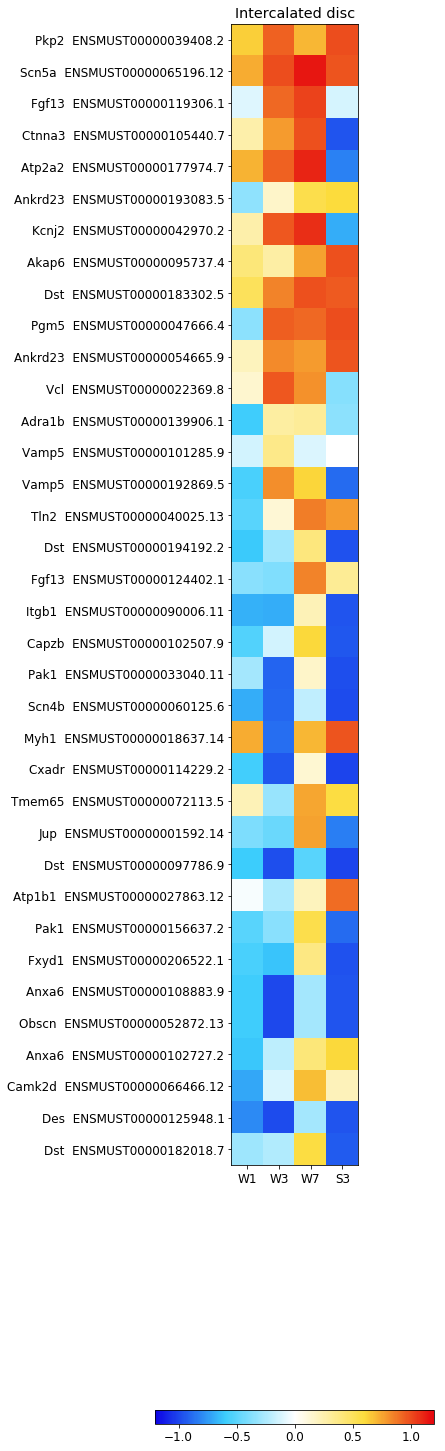

In [350]:
#Plot Data

# Declare parameters
color = ['#0d02e5','#3ccdfc','#ffffff','#fcdc3c','#e5020d']
fig, ax = plt.subplots()
#plt.rcParams['font.family'] = "Arial"
plt.rcParams.update({'font.size': 12})
plt.rcParams['savefig.bbox'] = 'tight'

# Create the colormap
cm = colors.LinearSegmentedColormap.from_list('my_list', color, N=256)

#Define bounds to colormap
bounds = np.arange(-1.2,1.2,0.001)
norm = colors.BoundaryNorm(bounds,cm.N)

# Apply colormap to data
im = ax.imshow(Z, origin='upper', cmap=cm, interpolation = "nearest", norm=norm, aspect='equal')
cb = fig.colorbar(im, ax=ax, cmap=cm, norm=norm, boundaries=bounds, orientation="horizontal")
cb.set_ticks([-1,-0.5,0,0.5,1],update_ticks=True)
ax.set_yticks(np.arange(0, len(Z), 1))
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(("W1","W3","W7","S3"))
ax.set_yticklabels(ylabels)
ax.set_title(colum)
fig_name = colum + ".png"


#fig.set_size_inches(10,100)
#fig.set_size_inches(10,40)
fig.set_size_inches(5,30)
#fig.set_size_inches(5,10)
#fig.set_size_inches(5,5)

plt.savefig(fig_name)
plt.show()

In [297]:
# Filtering transcripts by names using pandas string methods

#Kchan = siglist["Gene name"].loc[siglist["Gene name"].str.startswith('Cl',na=False)]

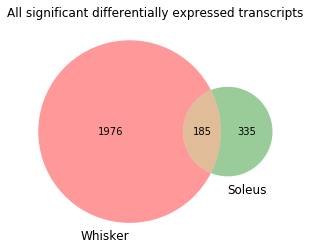

In [4]:
# Venn diagram of significant transcripts

from matplotlib_venn import venn2, venn3

v = venn2([set(wsig["target_id"].values), set(solsig["target_id"].values)], set_labels = ('Whisker','Soleus'))
#v.get_patch_by_id('01').set_color('#33cccc')
#v.get_patch_by_id('11').set_color('#cccc33')
#v.get_patch_by_id('10').set_color('#cc33cc')
plt.title('All significant differentially expressed transcripts')
plt.savefig("Total_venn.png")

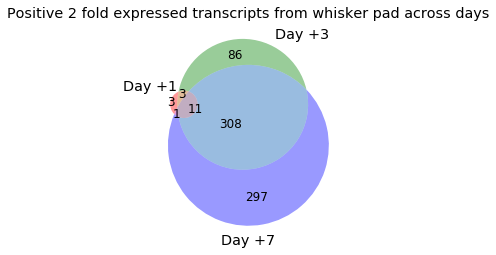

In [57]:
# Loading in Wald Test data in order to Venn diagram +/- FC time course

wtd1r = pd.read_csv('Day1R Wald.csv')
wtd3r = pd.read_csv('Day3R Wald.csv')
wtd7r = pd.read_csv('Day7R Wald.csv')
wtsol = pd.read_csv('WT_soleus.csv')

pos_wtd1r = set(wtd1r['target_id'].loc[wtd1r['LogFC'] >= 1].values)
pos_wtd3r = set(wtd3r['target_id'].loc[wtd3r['LogFC'] >= 1].values)
pos_wtd7r = set(wtd7r['target_id'].loc[wtd7r['LogFC'] >= 1].values)
pos_wtsol = set(wtsol['target_id'].loc[wtsol['LogFC'] >= 1].values)

neg_wtd1r = set(wtd1r['target_id'].loc[wtd1r['LogFC'] <= -1].values)
neg_wtd3r = set(wtd3r['target_id'].loc[wtd3r['LogFC'] <= -1].values)
neg_wtd7r = set(wtd7r['target_id'].loc[wtd7r['LogFC'] <= -1].values)
neg_wtsol = set(wtsol['target_id'].loc[wtsol['LogFC'] <= -1].values)

venn3([pos_wtd1r, pos_wtd3r, pos_wtd7r], set_labels = ('Day +1','Day +3','Day +7'))
plt.title('Positive 2 fold expressed transcripts from whisker pad across days')
plt.savefig("posWhisk_venn.png")

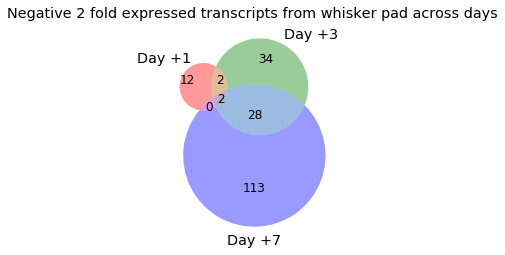

In [58]:
venn3([neg_wtd1r, neg_wtd3r, neg_wtd7r], set_labels = ('Day +1','Day +3','Day +7'))
plt.title('Negative 2 fold expressed transcripts from whisker pad across days')
plt.savefig("negWhisk_venn.png")

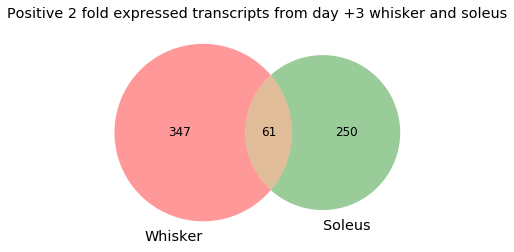

In [59]:
venn2([pos_wtd3r, pos_wtsol], set_labels = ('Whisker','Soleus'))
plt.title('Positive 2 fold expressed transcripts from day +3 whisker and soleus')
plt.savefig("posWvS_venn.png")

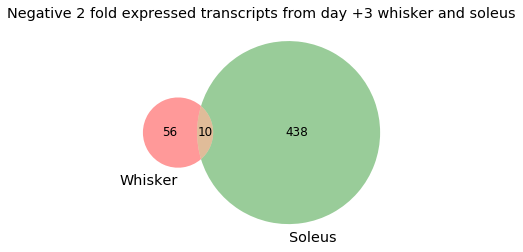

In [62]:
venn2([neg_wtd3r, neg_wtsol], set_labels = ('Whisker','Soleus'))
plt.title('Negative 2 fold expressed transcripts from day +3 whisker and soleus')
plt.savefig("negWvS_venn.png")

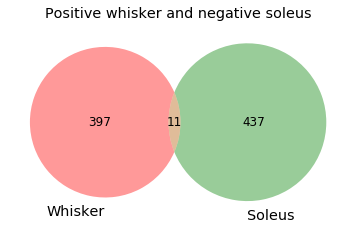

In [63]:
venn2([pos_wtd3r, neg_wtsol], set_labels = ('Whisker','Soleus'))
plt.title('Positive whisker and negative soleus')
plt.savefig("posWvnegS_venn.png")


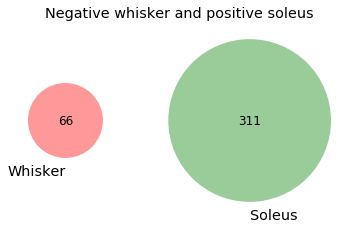

In [64]:
venn2([neg_wtd3r, pos_wtsol], set_labels = ('Whisker','Soleus'))
plt.title('Negative whisker and positive soleus')
plt.savefig("negWvposS_venn.png")

In [52]:
translist = pos_wtd3r & neg_wtsol
#Use the transcript list to select out corresponding z-score rows
ZW = zwhiszso.loc[zwhiszso["Transcript_ID"].isin(translist)].reset_index(drop=True)

#Isolate data into numpy matrix
Z = ZW.iloc[:,1:5].values

print(ZW)


            Transcript_ID       WD1       WD3       WD7       SD3      qval  \
0    ENSMUST00000053986.8 -0.606109  0.618759  0.362502 -0.966563  0.000134   
1    ENSMUST00000114195.7 -0.322076  0.455524  0.492887 -0.982001  0.001372   
2   ENSMUST00000028633.12  0.513468  0.219928  0.614838 -0.807284  0.002406   
3    ENSMUST00000061260.7  0.247672  0.245637  0.646102 -0.970963  0.004776   
4    ENSMUST00000019992.5  0.341735 -0.158133  0.566867 -0.920612  0.013502   
5   ENSMUST00000001181.12  0.543889 -0.098680  0.561677 -0.941978  0.010445   
6    ENSMUST00000029567.8  0.106303 -0.199698  0.528883 -0.984745  0.010420   
7   ENSMUST00000102917.10 -0.008330 -0.049908  0.824647 -0.939384  0.007587   
8    ENSMUST00000055071.8 -0.176744 -0.248942  0.249590 -0.927567  0.006514   
9    ENSMUST00000062010.9  0.986619 -0.208793 -0.236422 -0.700222  0.001223   
10   ENSMUST00000113516.1 -0.236813 -0.090054  0.217856 -0.996984  0.000275   

    Zbin  
0    1.0  
1    1.0  
2    1.0  
3    1.

In [ ]:
#Create y-labels
ylabels = translist["Gene name"].values + "  " + translist["target_id"].values

#Plot Data

# Declare parameters
color = ['#0d02e5','#3ccdfc','#ffffff','#fcdc3c','#e5020d']
fig, ax = plt.subplots()
#plt.rcParams['font.family'] = "Arial"
plt.rcParams.update({'font.size': 12})
plt.rcParams['savefig.bbox'] = 'tight'

# Create the colormap
cm = colors.LinearSegmentedColormap.from_list('my_list', color, N=256)

#Define bounds to colormap
bounds = np.arange(-1.2,1.2,0.001)
norm = colors.BoundaryNorm(bounds,cm.N)

# Apply colormap to data
im = ax.imshow(Z, origin='upper', cmap=cm, interpolation = "nearest", norm=norm, aspect='equal')
cb = fig.colorbar(im, ax=ax, cmap=cm, norm=norm, boundaries=bounds, orientation="horizontal")
cb.set_ticks([-1,-0.5,0,0.5,1],update_ticks=True)
ax.set_yticks(np.arange(0, len(Z), 1))
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(("W1","W3","W7","S3"))
ax.set_yticklabels(ylabels)
ax.set_title(colum)
fig_name = colum + ".png"


#fig.set_size_inches(10,100)
#fig.set_size_inches(10,40)
fig.set_size_inches(5,30)
#fig.set_size_inches(5,10)
#fig.set_size_inches(5,5)

plt.savefig(fig_name)
plt.show()
